# Plot and Database Class Examples

This notebook shows how some of the plot classes can be used in conjunction with the database module and it's respective helper classes.

I hope this can act as a template to generate further plots easily.

In [1]:
import sys

sys.path.append("../Source")

### Database class

Firstly, a pythonic way of creating queries is shown below using the SQLAlchemy core module using the db.query() method. Schemas are defined in the database.schemas module. This allows for column validation prior to the query being made.

Furthermore the db.query() method can accept raw sql text statements, handling both the opening and closure of connections.

If this does not suit your style, the database module also exposes a method for generating connections to use in the pandas read_sql function. This is advised method with pandas, however one must be careful with closure of connections.

In [2]:
from database import db # import the database helper class
from database.schemas import diasource, sssource # import the tables

In [3]:
from sqlalchemy import select 
import pandas as pd

In [4]:
# add required columns to the statement
cols = [
    diasource.c['filter'],
    diasource.c['midpointtai'], 
    sssource.c['topocentricx'],
    sssource.c['topocentricy'],
    sssource.c['topocentricz'],
    diasource.c['mag']
]

#add conditions to the statement
conditions = [
    diasource.c['midpointtai'] >= 60042,
    diasource.c['midpointtai'] <= 60043,
]

#create the SQLAlchemy statement
stmt = select(*cols).join(sssource, sssource.c['ssobjectid'] == diasource.c['ssobjectid']).where(*conditions).limit(10000)

In [5]:
# The statement can be converted to raw SQL if one wishes
str(stmt)

'SELECT diasources.filter, diasources.midpointtai, sssources.topocentricx, sssources.topocentricy, sssources.topocentricz, diasources.mag \nFROM diasources JOIN sssources ON sssources.ssobjectid = diasources.ssobjectid \nWHERE diasources.midpointtai >= :midpointtai_1 AND diasources.midpointtai <= :midpointtai_2\n LIMIT :param_1'

In [6]:
#Using the query method
df = db.query(
    stmt
)

It is also possible to return the SQLAlchemy cursor which consumes much less memory than the pandas dataframe.It is iterable and it may be useful for very large results.

In [7]:
%%time
non_df = db.query(
    stmt = stmt,
    return_as_df = False
)

CPU times: user 11.7 ms, sys: 4.04 ms, total: 15.7 ms
Wall time: 505 ms


In [8]:
print(f"The size of the dataframe is {sys.getsizeof(df)} bytes")
print(f"The size of the SQLAlchemy cursor result is {sys.getsizeof(non_df)} bytes")

print(f"SQLAlchemy cursor takes up {100*sys.getsizeof(non_df)/sys.getsizeof(df)} % of the memory that the dataframe takes up.")

The size of the dataframe is 980144 bytes
The size of the SQLAlchemy cursor result is 48 bytes
SQLAlchemy cursor takes up 0.00489723958928484 % of the memory that the dataframe takes up.


Using a raw SQL text statement in the query function is also possible.

In [9]:
%%time
__df = db.query(
    f"""
        SELECT diasources.filter, diasources.midpointtai, sssources.topocentricx, 
        sssources.topocentricy, sssources.topocentricz, diasources.mag
        FROM diasources JOIN sssources ON sssources.ssobjectid = diasources.ssobjectid 

        WHERE diasources.midpointtai >= {60042} AND diasources.midpointtai <= {60044}

        LIMIT 10000
        """
)

CPU times: user 42.5 ms, sys: 13 ms, total: 55.5 ms
Wall time: 1.91 s


Using the generate_connection() method along with pandas read_sql

In [10]:
%%time
conn = db.generate_connection()
with conn: # with statement closes connection
    _df = pd.read_sql(
        f"""
        SELECT diasources.filter, diasources.midpointtai, sssources.topocentricx, 
        sssources.topocentricy, sssources.topocentricz, diasources.mag
        FROM diasources JOIN sssources ON sssources.ssobjectid = diasources.ssobjectid 

        WHERE diasources.midpointtai >= {60042} AND diasources.midpointtai <= {60044}

        LIMIT 10000
        """,
        conn
    )

CPU times: user 111 ms, sys: 1.22 ms, total: 112 ms
Wall time: 405 ms


Note: it is also possible to create multiple queries using the same connection using the db.transaction() method as shown below by providing a list of statements. This returns a list of dataframes.

In [11]:
multi_df = db.transaction(
    [
         f"""
        SELECT diasources.filter, diasources.midpointtai, sssources.topocentricx, 
        sssources.topocentricy, sssources.topocentricz, diasources.mag
        FROM diasources JOIN sssources ON sssources.ssobjectid = diasources.ssobjectid 

        WHERE diasources.midpointtai >= {60042} AND diasources.midpointtai <= {60044}

        LIMIT 1000
        """,
         f"""
        SELECT diasources.filter, diasources.midpointtai, sssources.topocentricx, 
        sssources.topocentricy, sssources.topocentricz, diasources.mag
        FROM diasources JOIN sssources ON sssources.ssobjectid = diasources.ssobjectid 

        WHERE diasources.midpointtai >= {60045} AND diasources.midpointtai <= {60046}

        LIMIT 1000
        """
    ]
)

In [12]:
multi_df

[    filter   midpointtai  topocentricx  topocentricy  topocentricz        mag
 0        i  60042.000096     -0.646707      2.133366      1.079788  21.292732
 1        i  60042.000096     -0.700984      2.170930      1.109775  21.292732
 2        i  60042.000096     -0.701166      2.171049      1.109870  21.292732
 3        i  60042.000096     -0.667895      2.148876      1.092066  21.292732
 4        i  60042.000096     -0.667720      2.148748      1.091966  21.292732
 ..     ...           ...           ...           ...           ...        ...
 995      i  60042.000096      0.434275     -1.253829     -0.805254  22.159080
 996      i  60042.000096      0.434168     -1.253705     -0.805188  22.159080
 997      i  60042.000096      0.434424     -1.254002     -0.805346  22.159080
 998      i  60042.000096      0.434318     -1.253878     -0.805281  22.159080
 999      i  60042.000096      0.439535     -1.260312     -0.808700  22.159080
 
 [1000 rows x 6 columns],
     filter   midpointta

# Plotting classes

## Scatter plot

The ScatterPlot class provides functionality to generate scatter plots whilst maintaining the ability to show, edit and save plots that comes with matplotlib and seaborn.

In [13]:
from plots import ScatterPlot

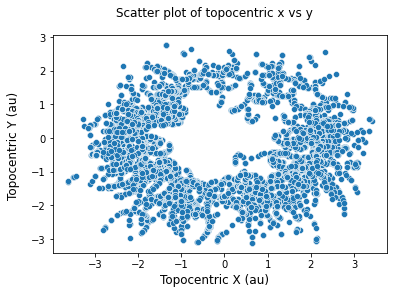

In [14]:
scatter_example = ScatterPlot(
    data = df,
    x = "topocentricx",
    y = "topocentricy",
    xlabel = "Topocentric X (au)",
    ylabel = "Topocentric Y (au)",
    title = "Scatter plot of topocentric x vs y",
    cache_data = True # keeps data associated with plots for follow up
)

In [15]:
#instance
scatter_example

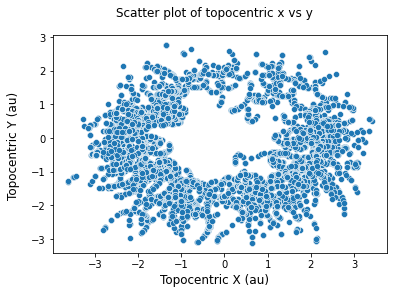

In [16]:
# figure attribute
scatter_example.fig

In [17]:
# The figure attribute can be edited using matplotlib methods, 
#ie here we change the size, for example;
scatter_example.fig.set_figwidth(8)
scatter_example.fig.set_figheight(8)

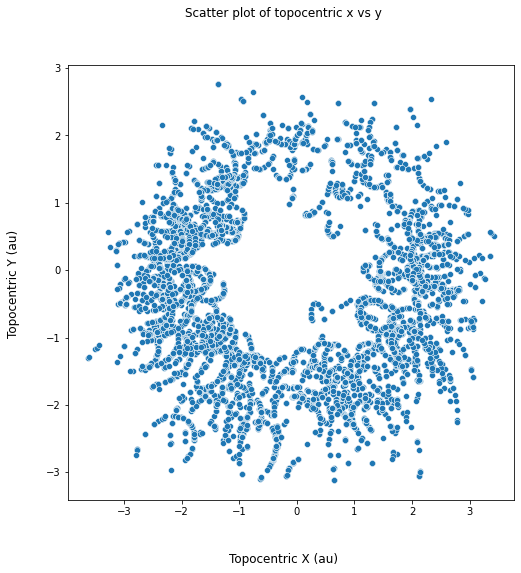

In [18]:
scatter_example.fig

Underlying axes are available through the ax attribute

In [19]:
# The ax attribute exposes the axes and too can be edited.
scatter_example.ax

<AxesSubplot:>

In [20]:
scatter_example.fig.supxlabel("Updated Topocentric X(au)") # need to fix this
scatter_example.fig.suptitle("Updated title")

Text(0.5, 0.98, 'Updated title')

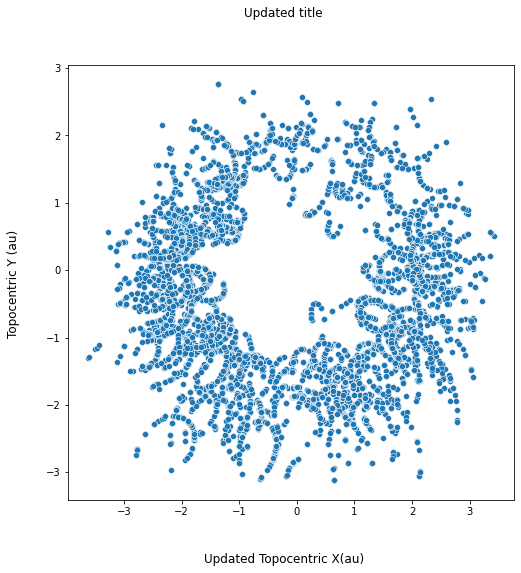

In [21]:
scatter_example.fig

If one would like to save the plot we can use the save(plot_name, file_extension) method to carry this out

In [22]:
scatter_example.save("plot_name", "png")

In [23]:
#access the dataframe we previously passed to the plot. 
scatter_example.data

,filter,midpointtai,topocentricx,topocentricy,topocentricz,mag
0,y,60042.416594,2.126635,-3.036644,-0.596742,21.453224
1,y,60042.416594,2.124421,-3.056615,-0.604479,21.453224
2,y,60042.416594,2.131399,-2.978791,-0.574375,21.453224
3,y,60042.416594,2.130105,-2.997817,-0.581723,21.453224
4,y,60042.416594,2.124438,-3.056457,-0.604418,21.453224
...,...,...,...,...,...,...
9995,i,60042.127326,-1.586992,-1.867328,-0.886991,22.289827
9996,i,60042.127326,-1.587104,-1.867242,-0.886954,22.289827
9997,i,60042.127326,-1.527003,-1.933505,-0.915525,22.289827
9998,i,60042.127326,-1.523044,-1.940050,-0.918349,22.289827


A useful workflow for regenerating graphs may be to filter the returned dataframe as required and regenerate the plot easily using the class.

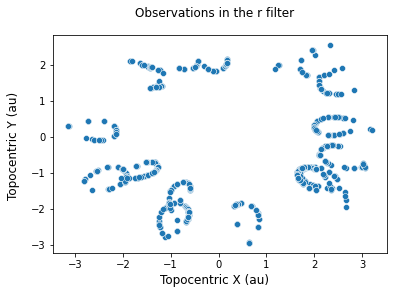

In [24]:
new_scatter_example = ScatterPlot(
    data = df[df['filter'] == 'r'],
    x = "topocentricx",
    y = "topocentricy",
    title = "Observations in the r filter",
    xlabel = "Topocentric X (au)",
    ylabel = "Topocentric Y (au)",
    cache_data = False
)

In [25]:
# Again, we can make any edits provided by matplotlib
new_scatter_example.fig.set_facecolor("#9a9a9a")
new_scatter_example.ax.set_xticks(ticks = [-3, 0 , 3])

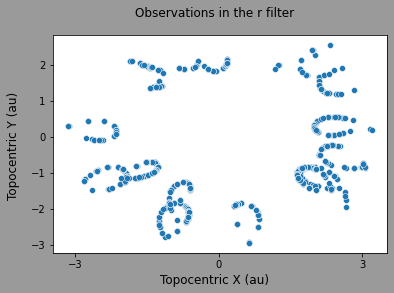

In [26]:
new_scatter_example.fig

We can see all of the edits we can make to the plot by calling the attribute and method lost underlying the matplotlib/seaborn plot

In [27]:
dir(scatter_example.fig)

['_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_axes_internal',
 '_agg_filter',
 '_align_label_groups',
 '_alpha',
 '_animated',
 '_axobservers',
 '_axstack',
 '_button_pick_id',
 '_cachedRenderer',
 '_callbacks',
 '_canvas_callbacks',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_constrained',
 '_constrained_layout_pads',
 '_default_contains',
 '_dpi',
 '_gci',
 '_get_clipping_extent_bbox',
 '_get_dpi',
 '_get_draw_artists',
 '_gid',
 '_gridspecs',
 '_in_layout',
 '_label',
 '_localaxes',
 '_mouseover',
 '_normalize_grid_string',
 '_original_dpi',
 '_path_effects',
 '_picker',
 '_process_projection_r

In [28]:
dir(scatter_example.ax)

['ArtistList',
 '_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axis_names',
 '_axisbelow',
 '_box_aspect',
 '_callbacks',
 '_check_no_units',
 '_children',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_colorbars',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_deprecate_noninstance',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_

## 2D Histogram

In [29]:
from plots import Histogram2D

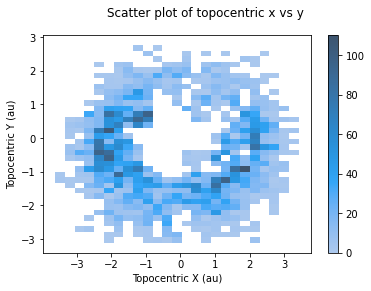

In [30]:
histogram = Histogram2D(
    data = df,
    x = "topocentricx",
    y = "topocentricy",
    xlabel = "Topocentric X (au)",
    ylabel = "Topocentric Y (au)",
    title = "Scatter plot of topocentric x vs y",
    cache_data = True, # keeps data associated with plots for follow up
    #marginals = True
)

## Hexplot

In [31]:
from plots import HexagonalPlot

<Figure size 432x288 with 0 Axes>

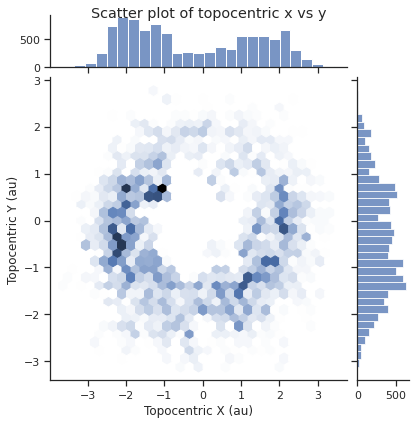

In [32]:
histogram = HexagonalPlot(
    data = df,
    x = "topocentricx",
    y = "topocentricy",
    xlabel = "Topocentric X (au)",
    ylabel = "Topocentric Y (au)",
    title = "Scatter plot of topocentric x vs y",
    cache_data = True, # keeps data associated with plots for follow up
    #marginals = True
)

## Box Plot

In [33]:
from plots import BoxPlot

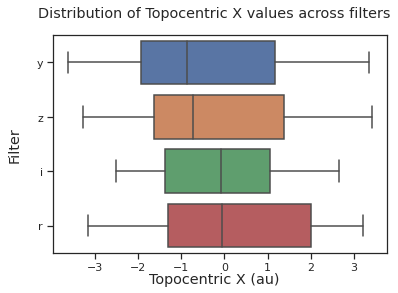

In [34]:
box = BoxPlot(
    data = df,
    x = "topocentricx",
    y = "filter",
    xlabel = "Topocentric X (au)",
    ylabel = "Filter",
    title = "Distribution of Topocentric X values across filters"
)

## Violin Plot

In [35]:
from plots import ViolinPlot

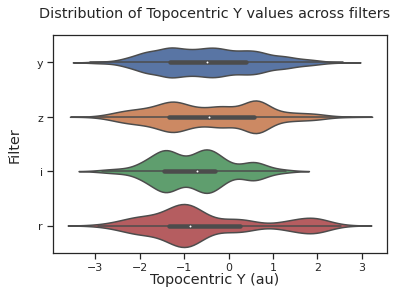

In [36]:
violin = ViolinPlot(
    data = df,
    x = "topocentricy",
    y = "filter",
    xlabel = "Topocentric Y (au)",
    ylabel = "Filter",
    title = "Distribution of Topocentric Y values across filters"
)

## Boxen Plot

In [37]:
from plots import BoxenPlot

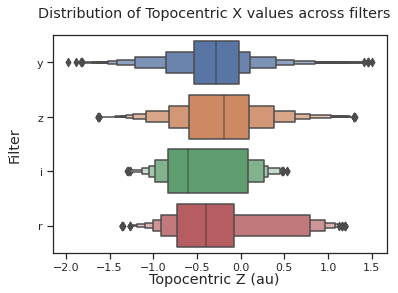

In [38]:
boxen = BoxenPlot(
    data = df,
    x = "topocentricz",
    y = "filter",
    xlabel = "Topocentric Z (au)",
    ylabel = "Filter",
    title = "Distribution of Topocentric X values across filters"
)

## Histogram Plot

In [39]:
from plots import HistogramPlot

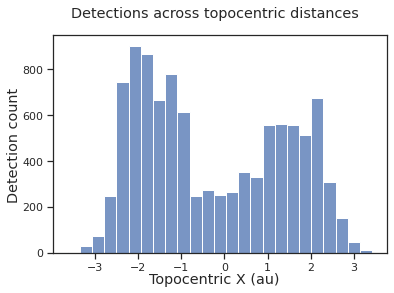

In [40]:
hist = HistogramPlot(
    data = df,
    x = "topocentricx",
    xlabel = "Topocentric X (au)",
    ylabel = "Detection count",
    title = "Detections across topocentric distances"
)